# Проект

[Ссылка](https://www.kaggle.com/t/e80ba755630c4c2e89f12ce652e2e732) для присоединения к соревнованию, там содержится детальная информация о проекте


# Импорты

In [1]:
import sys
import pandas as pd
from matplotlib import pyplot as plt

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    !pip install pytorch_lightning
    !pip install gensim
    !pip install catboost

import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import lightning as pl

# Для более качественных графиков
%config InlineBackend.figure_format='retina'
plt.rcParams["figure.dpi"] = 150

# Вычисления и слои в PyTorch

In [2]:
X = torch.tensor([10, 5, 20]).float()

num_inputs = 3
num_outputs = 1
neuron = nn.Linear(num_inputs, num_outputs)
neuron(X)

tensor([-9.1429], grad_fn=<ViewBackward0>)

In [3]:
num_outputs = 1
neuron = nn.Linear(num_inputs, num_outputs)
neuron(X)

tensor([-8.5975], grad_fn=<ViewBackward0>)

In [4]:
act = torch.nn.ReLU()
act(torch.tensor([12.0])), act(torch.tensor([-11.0]))

(tensor([12.]), tensor([0.]))

In [5]:
num_outputs = 10
neuron = torch.nn.Linear(num_inputs, num_outputs)
act(neuron(X))

tensor([0.0000, 0.0000, 6.5196, 0.0000, 8.9882, 2.6266, 0.0000, 0.0000, 1.0238,
        2.4741], grad_fn=<ReluBackward0>)

In [6]:
network = nn.Sequential(
    nn.Linear(3, 10),
    nn.ReLU(),
    nn.Linear(10, 5),
    nn.ReLU(),
)
network(X)

tensor([0.2961, 2.4850, 2.8350, 2.8231, 1.4807], grad_fn=<ReluBackward0>)

# Датасеты и обучение моделей

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/user/Main/Repos/hse-ml-managers/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default

  | Name      | Type       | Params | Mode 
-------------------------------------------------
0 | model     | Sequential | 321    | train
1 | criterion | MSE

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/user/Main/Repos/hse-ml-managers/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


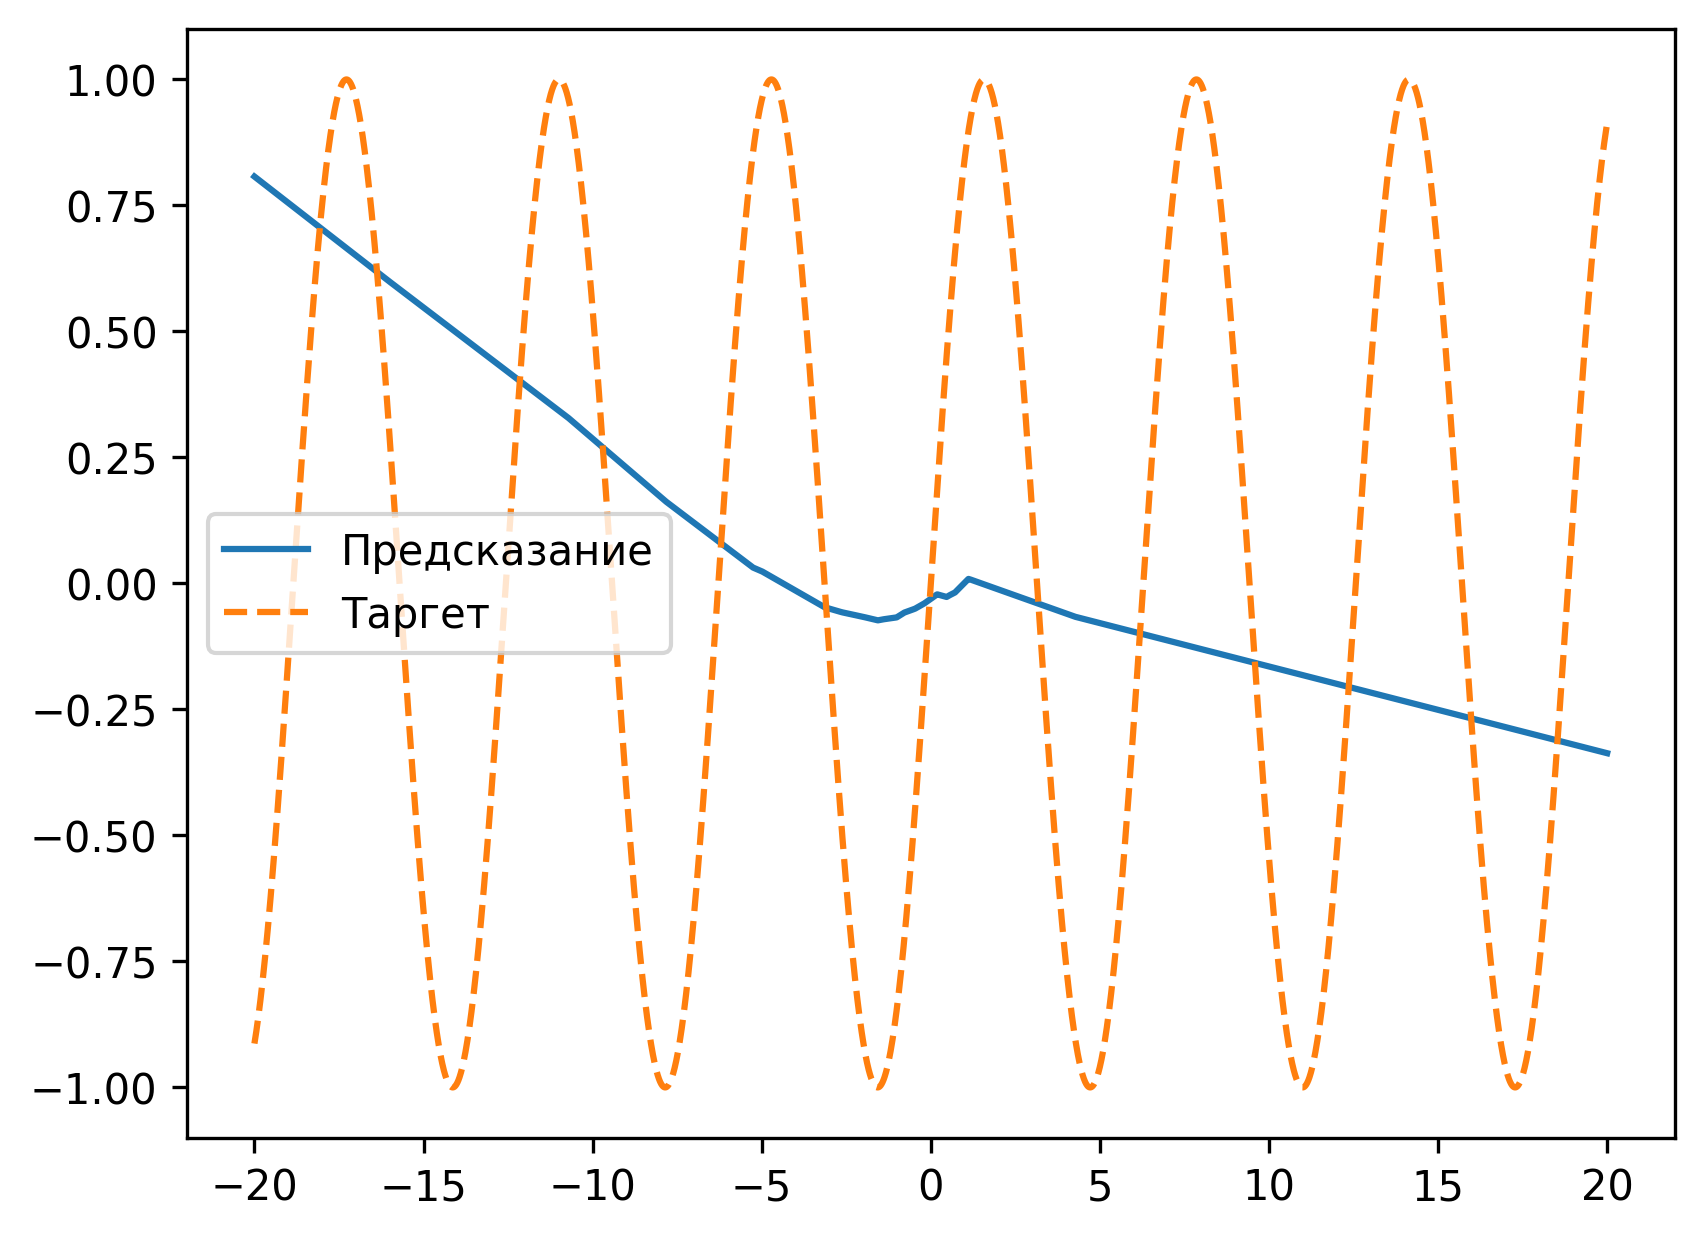

/Users/user/Main/Repos/hse-ml-managers/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

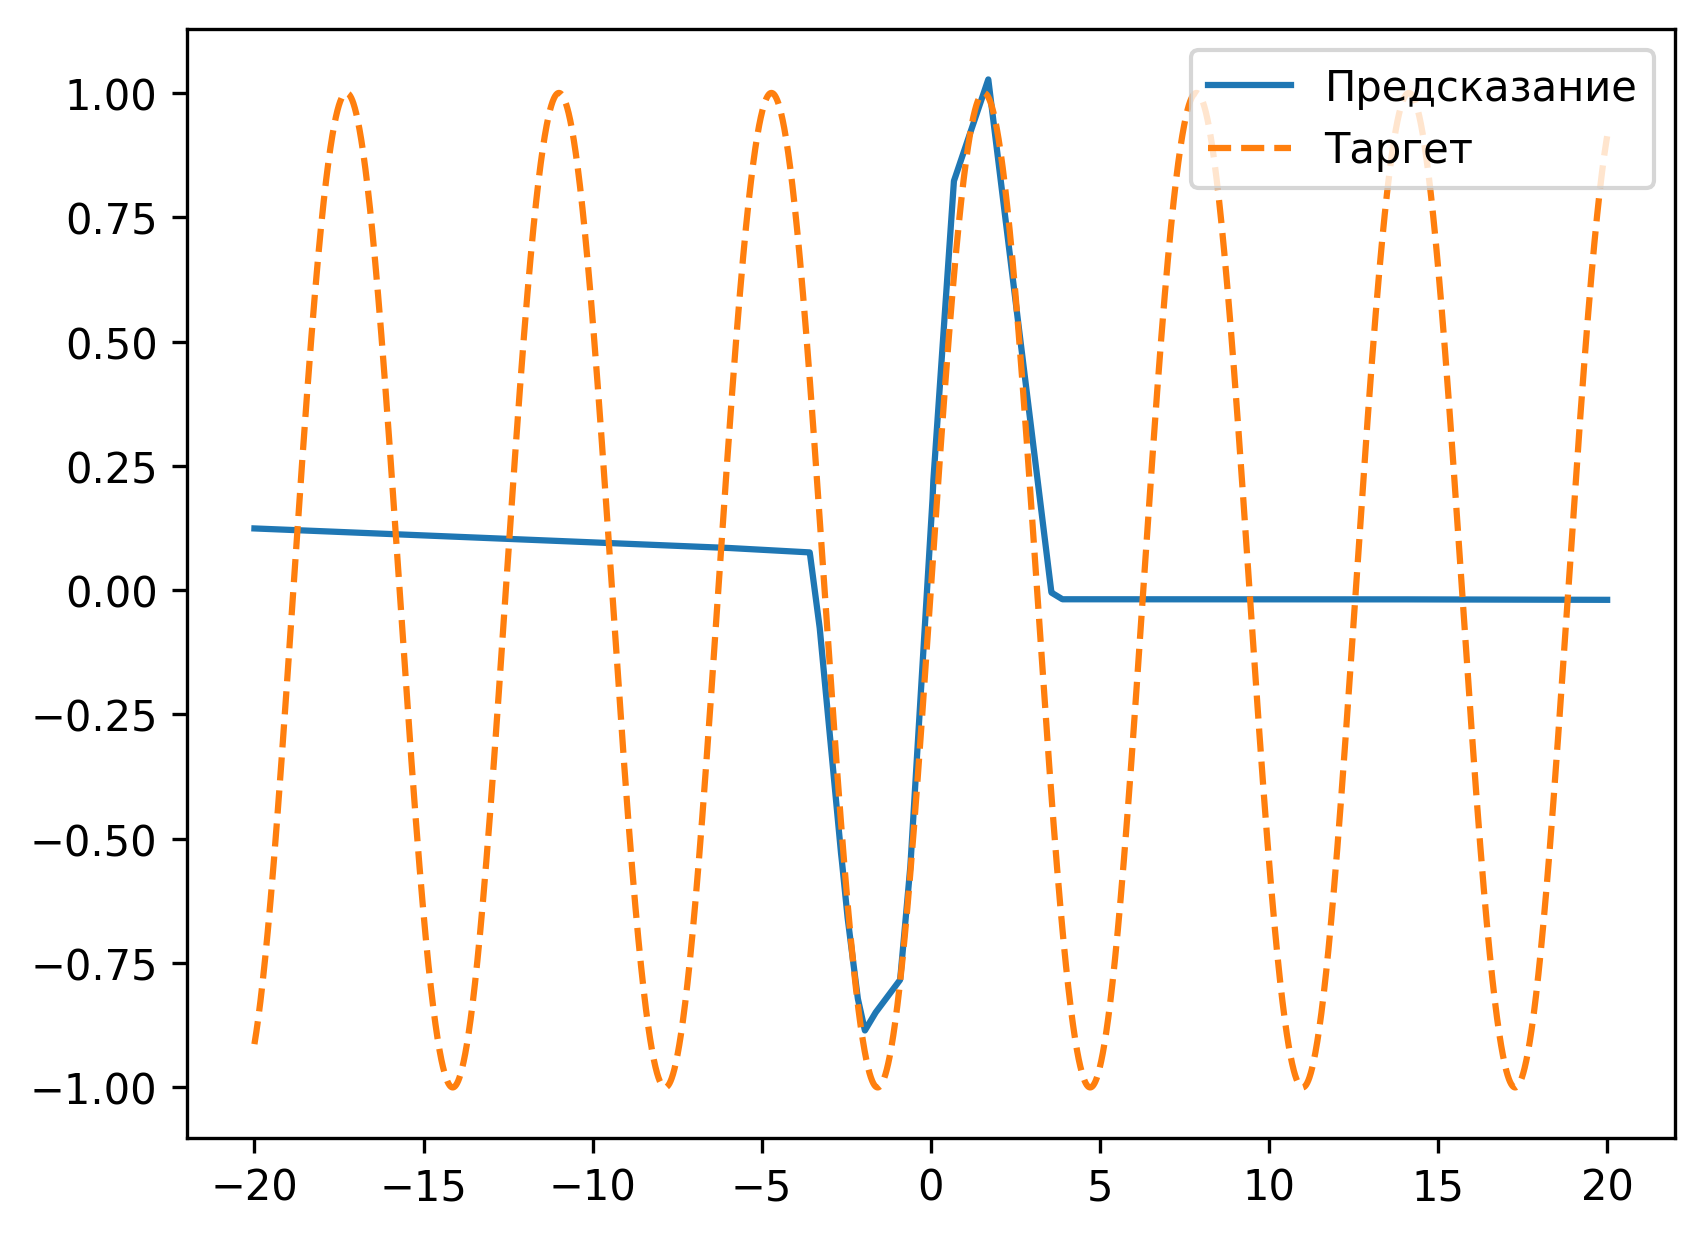

Validation: |          | 0/? [00:00<?, ?it/s]

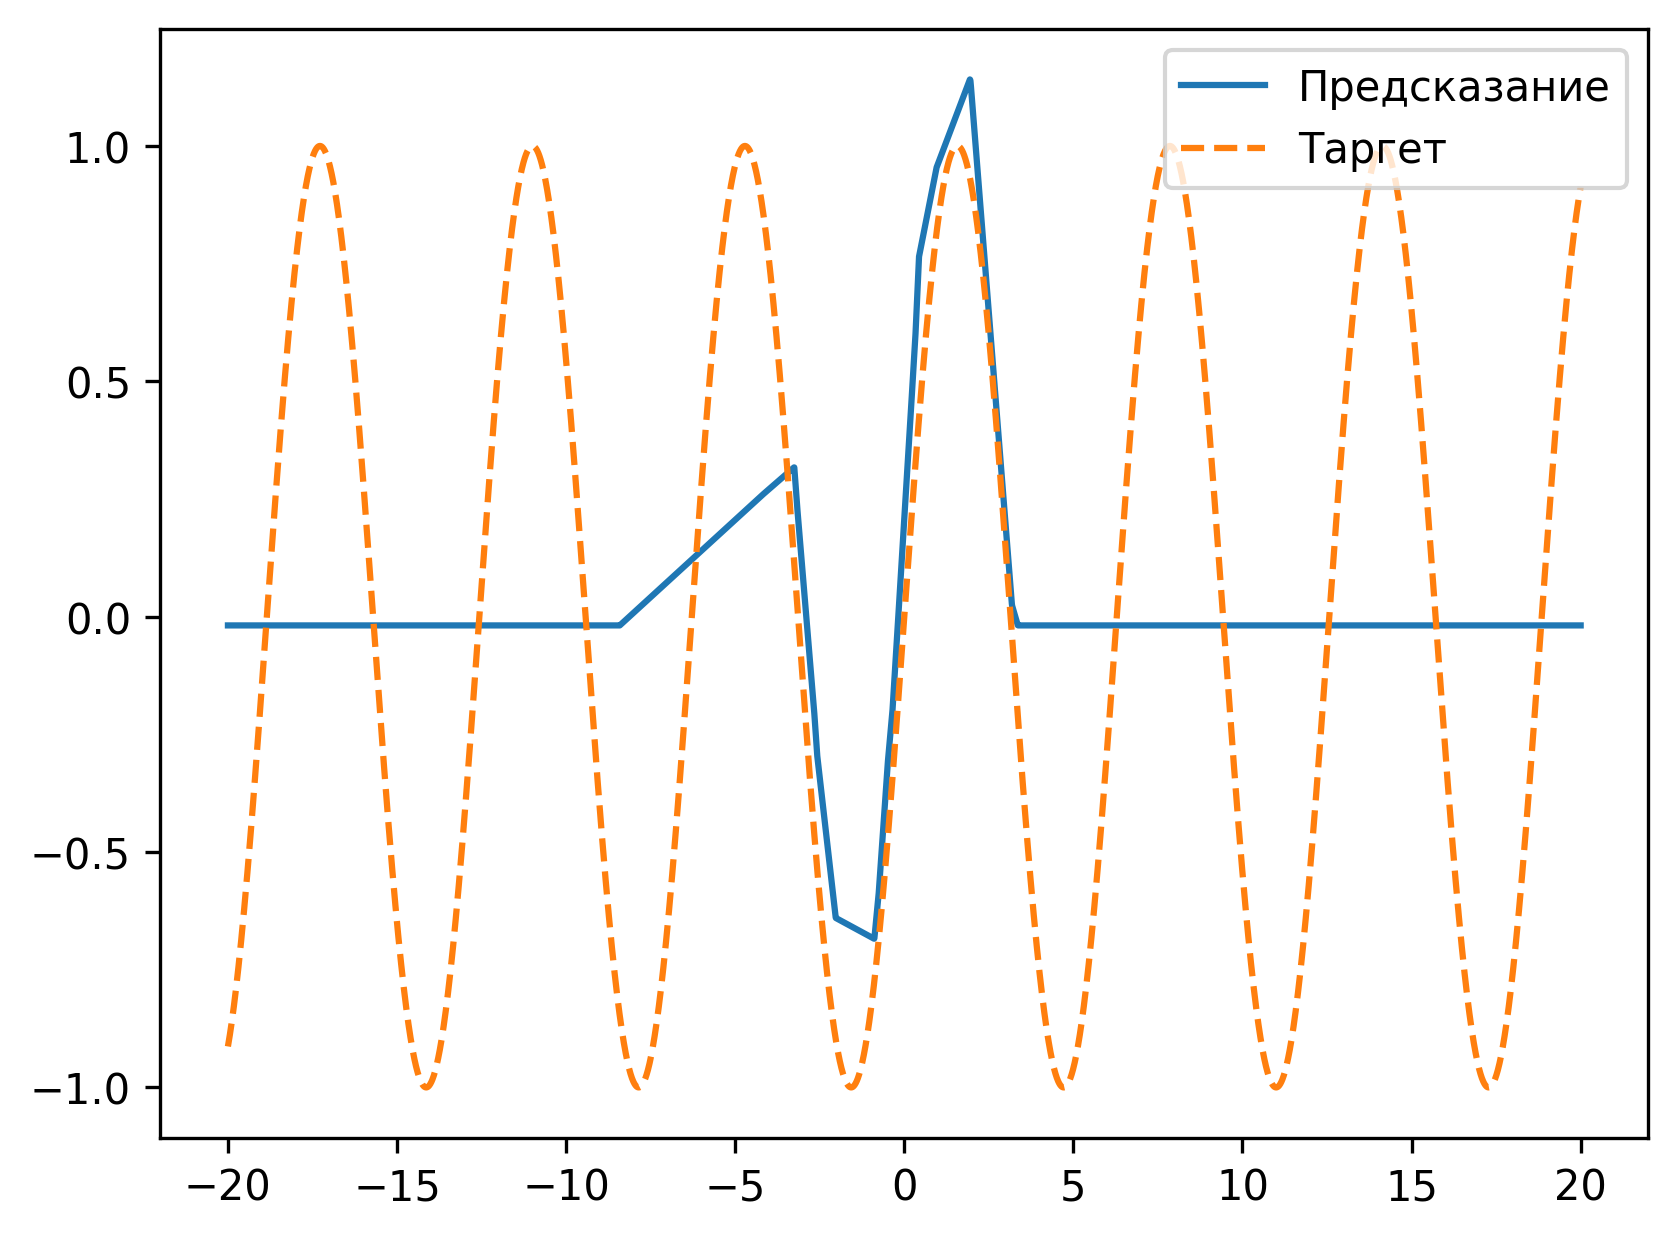

Validation: |          | 0/? [00:00<?, ?it/s]

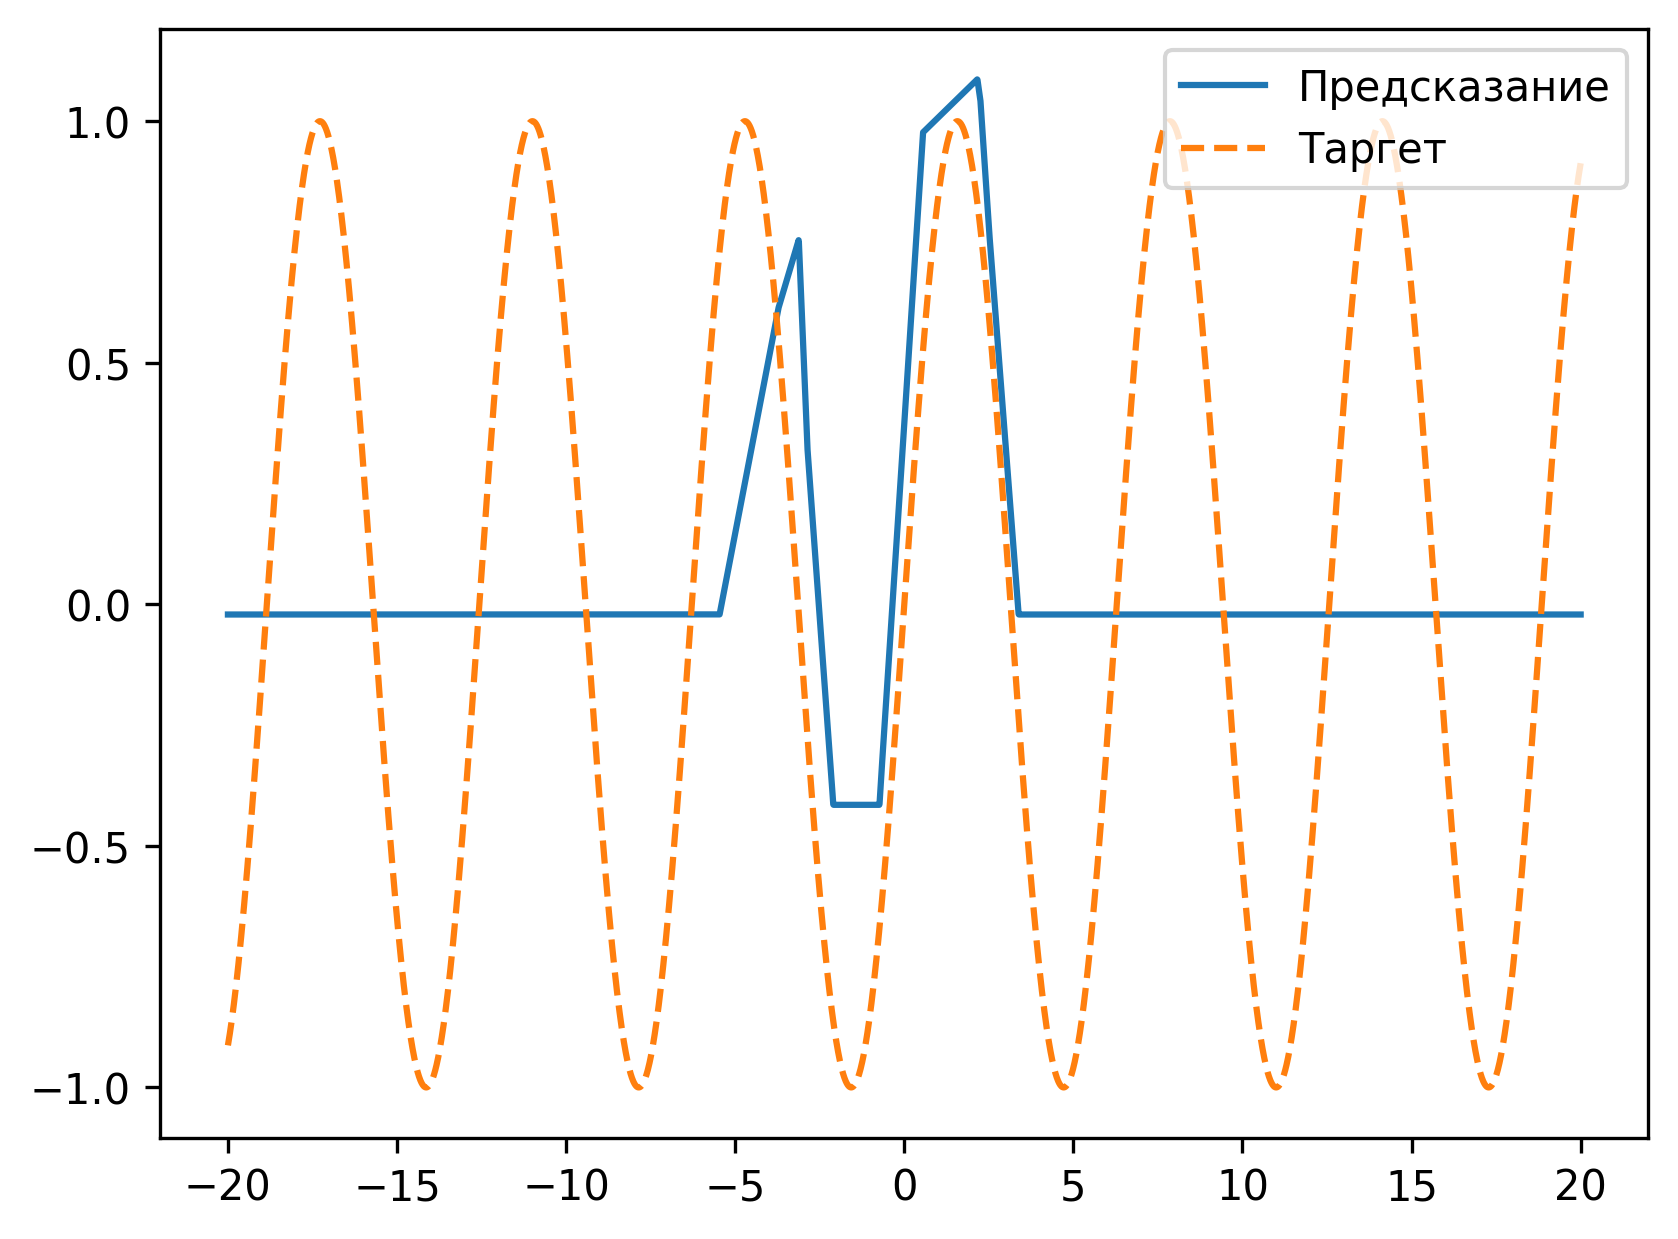

Validation: |          | 0/? [00:00<?, ?it/s]

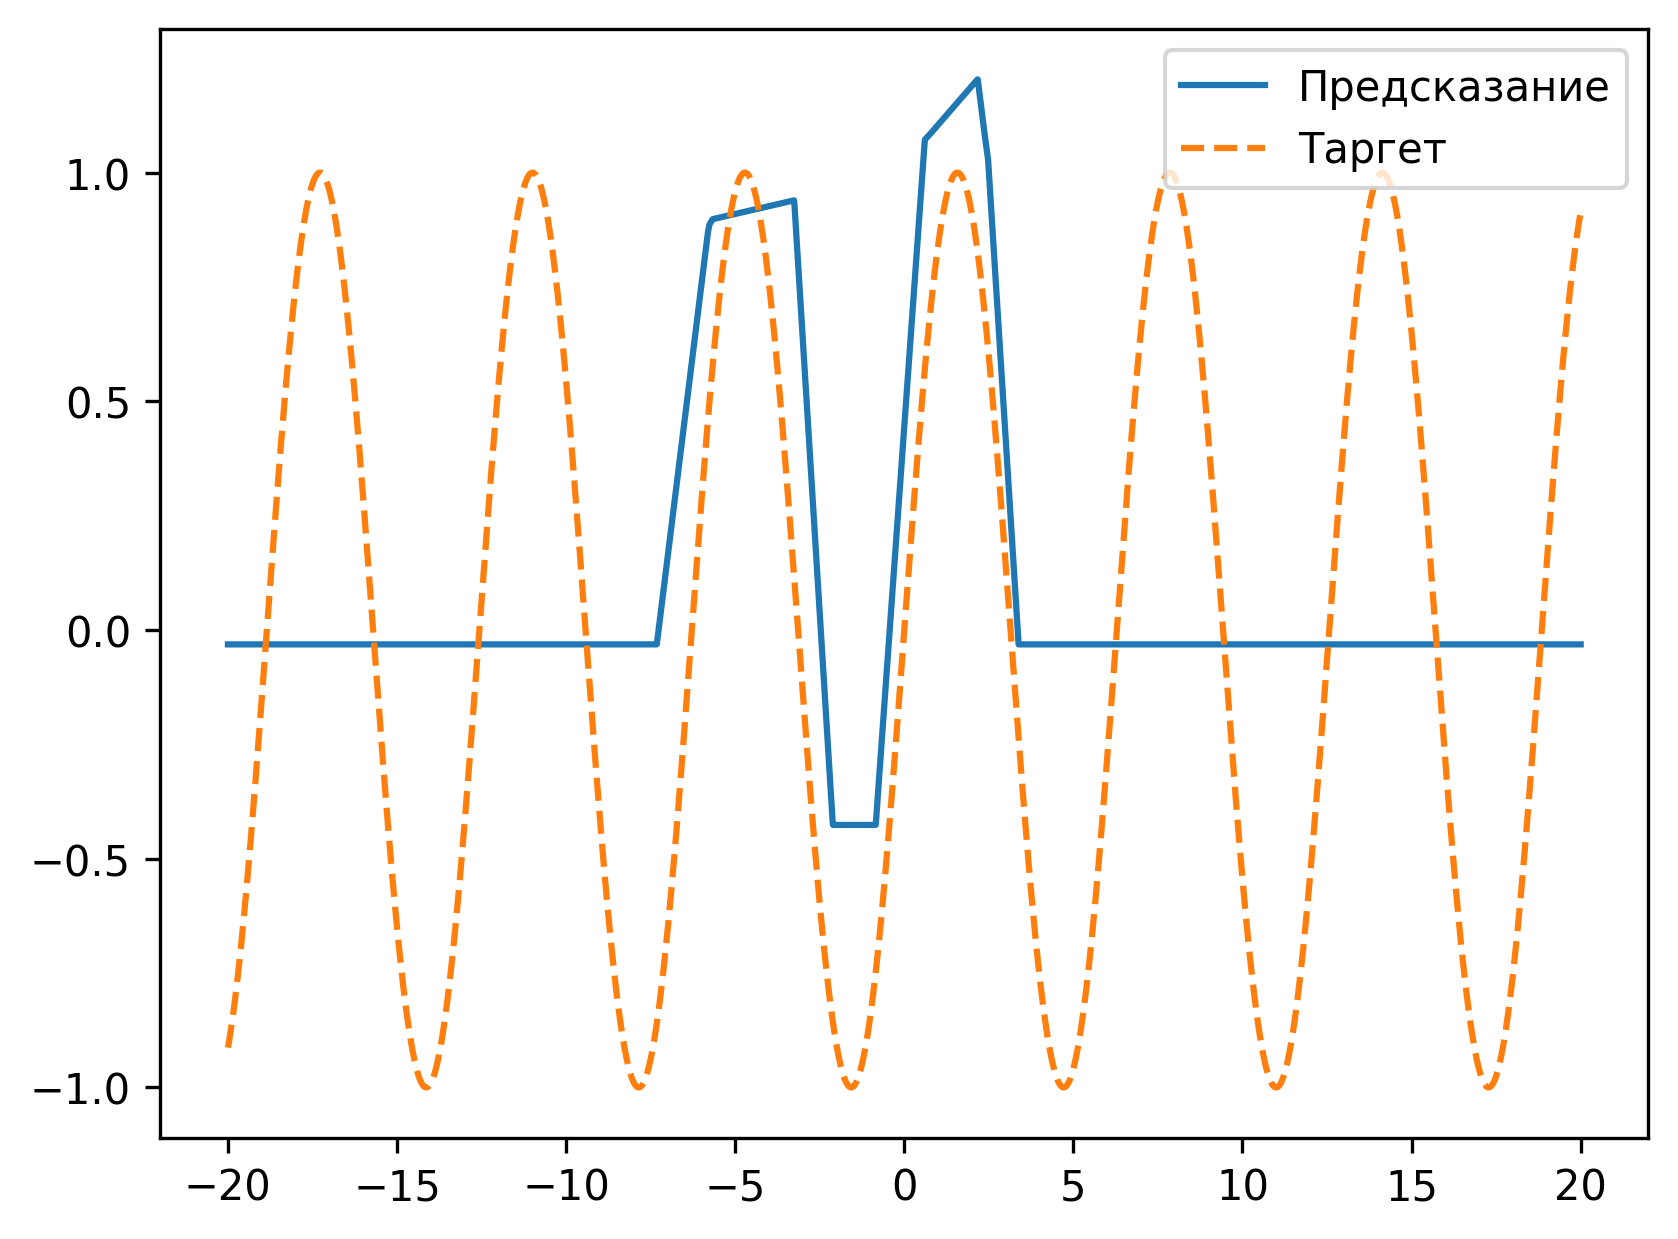

Validation: |          | 0/? [00:00<?, ?it/s]

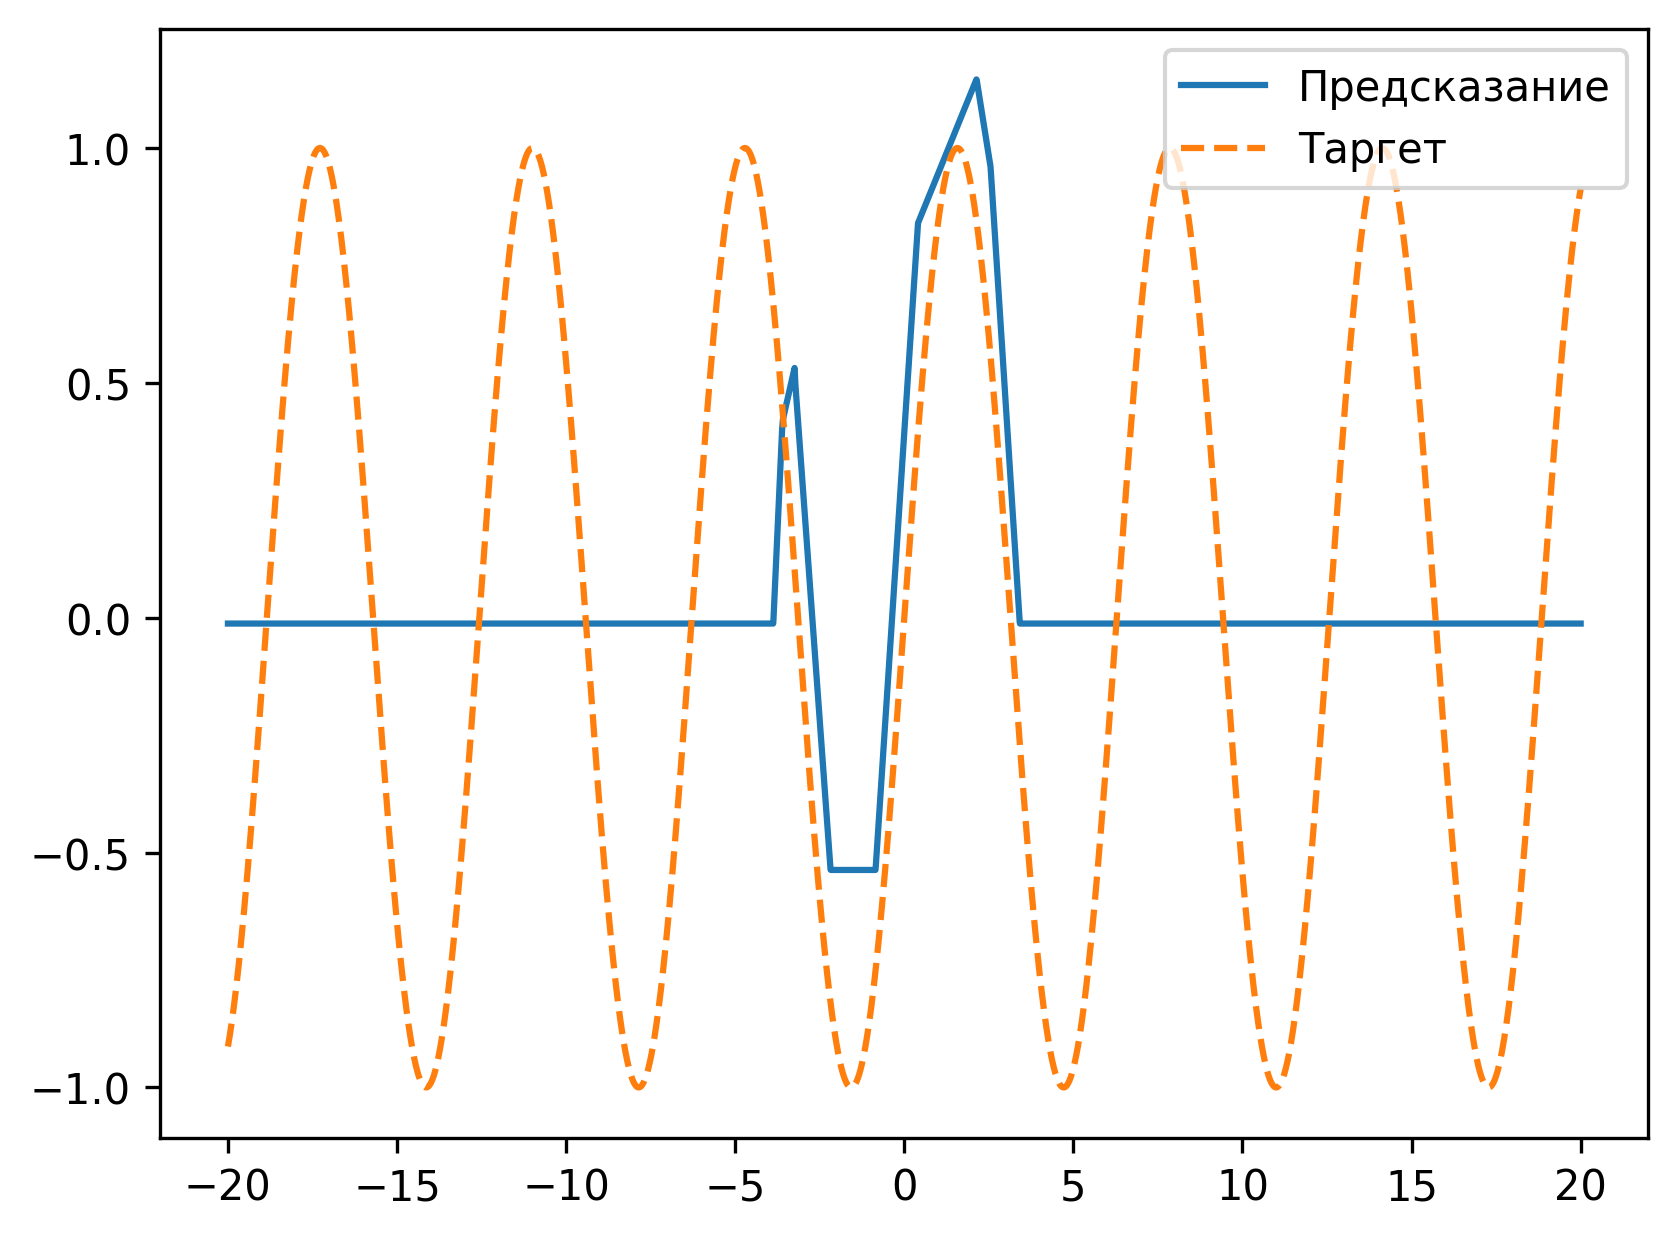

Validation: |          | 0/? [00:00<?, ?it/s]

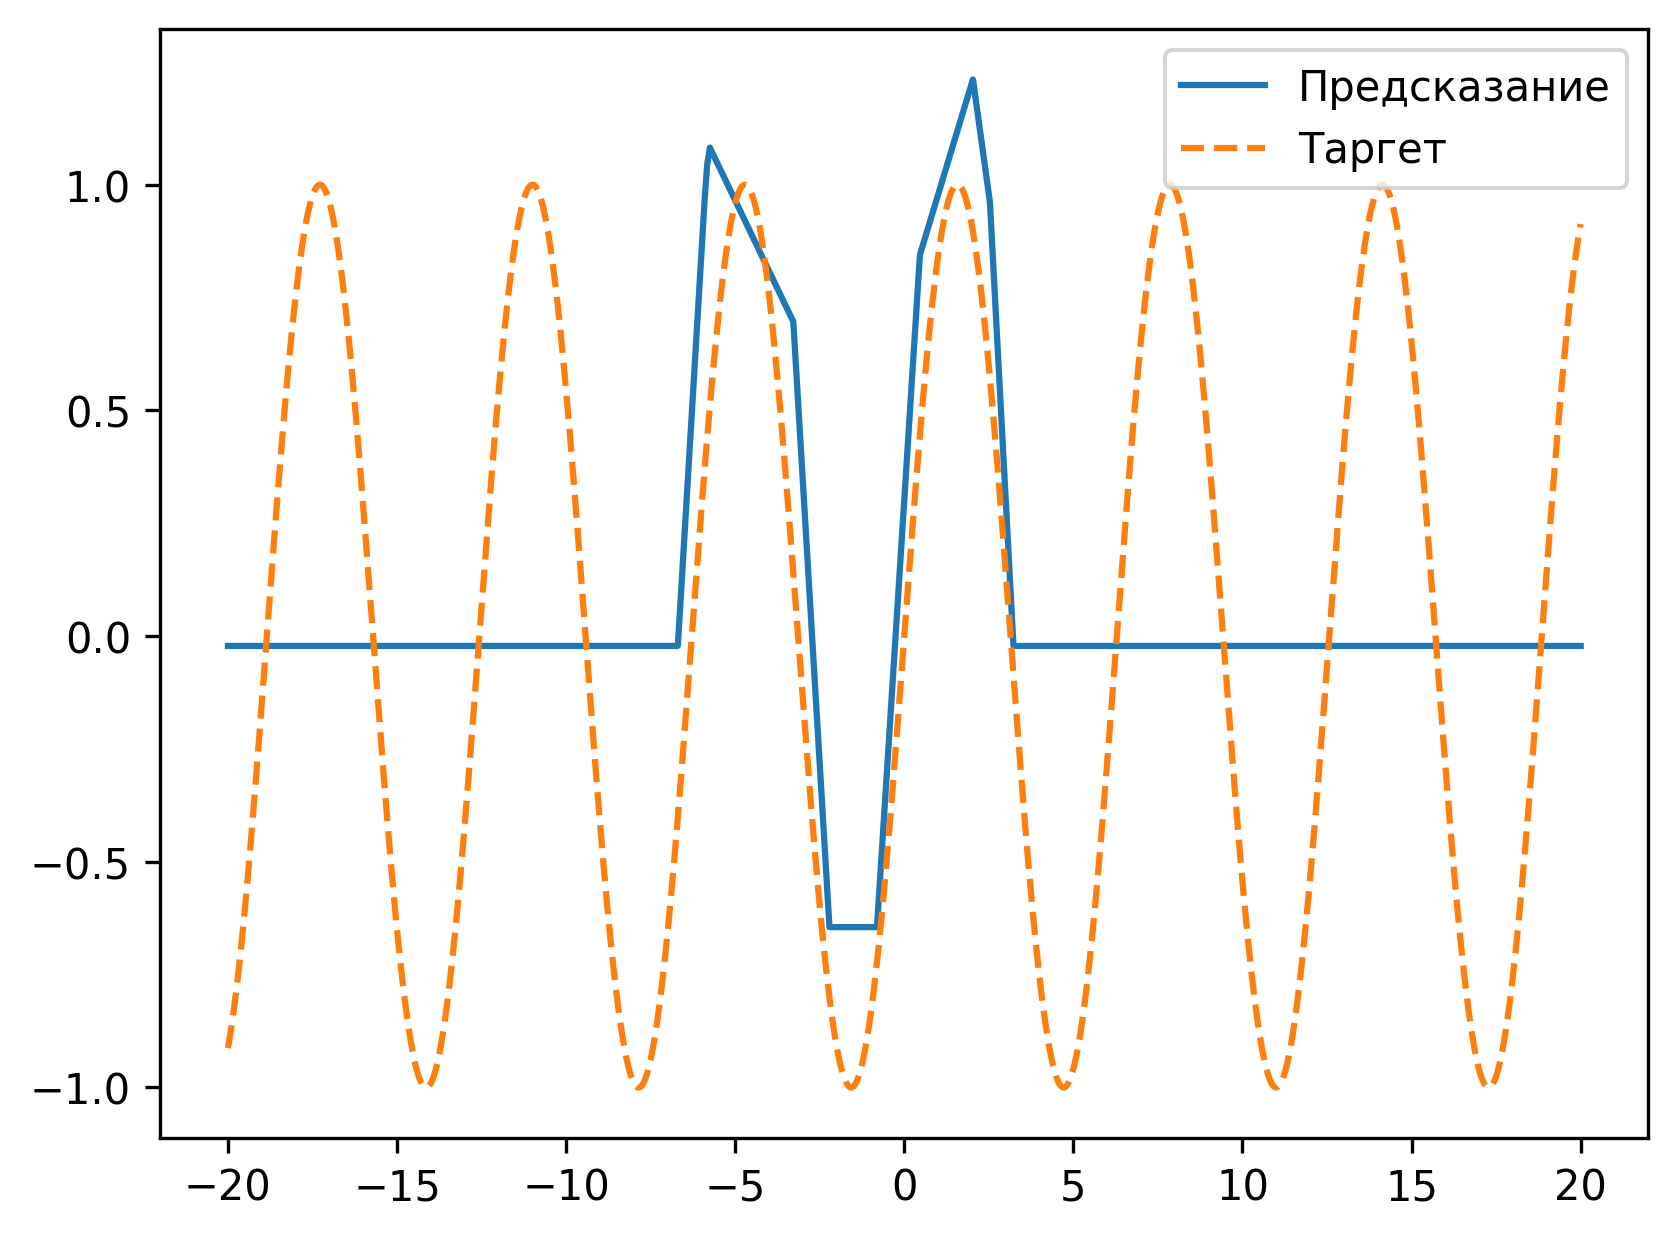

`Trainer.fit` stopped: `max_epochs=300` reached.


In [7]:
class SinDataset(Dataset):
    def __init__(self, start, end, num_samples):
        self.x = torch.linspace(start, end, num_samples)[:, None]
        self.y = torch.sin(self.x)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]


class SinModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(1, 16),
            nn.ReLU(),
            nn.Linear(16, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
        )
        self.criterion = nn.MSELoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch):
        x, y = batch
        pred = self(x)
        loss = self.criterion(pred, y)
        return loss

    @torch.no_grad
    def validation_step(self, batch):
        x, y = batch
        pred = self(x)

        x = x.flatten().cpu()
        y = y.flatten().cpu()
        pred = pred.flatten().cpu().detach()

        plt.plot(x, pred, label="Предсказание")
        plt.plot(x, y, linestyle="--", label="Таргет")
        plt.legend()
        plt.show()

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=0.01)


dataset = SinDataset(start=-20, end=20, num_samples=5000)
dataloader = DataLoader(dataset, batch_size=100)
val_dataloader = DataLoader(dataset, batch_size=5000, shuffle=False)

model = SinModel()
trainer = pl.Trainer(max_epochs=300, check_val_every_n_epoch=50)
trainer.fit(model, dataloader, val_dataloader)

__Задача__: попробуйте изменить архитектуру нн так, чтобы она предсказала правильно два цикла (например, значения на интервале -5, 7)

In [11]:
import warnings


class HousingDataset(Dataset):
    def __init__(self, X, y):
        self.x = torch.tensor(X.to_numpy(), dtype=torch.float)
        self.y = torch.tensor(y.to_numpy(), dtype=torch.float)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]


class HouseModel(pl.LightningModule):
    def __init__(self, in_dim, lr):
        super().__init__()
        self.lr = lr
        self.model = nn.Sequential(
            nn.Linear(in_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
        )
        self.criterion = nn.MSELoss()

    def forward(self, x):
        return self.model(x).flatten()

    def training_step(self, batch):
        x, y = batch
        pred = self(x)
        loss = self.criterion(pred, y)
        return loss

    @torch.no_grad
    def validation_step(self, batch, batch_idx: int = 0):
        if batch_idx > 0:
            return
        x, y = batch
        pred = self(x).flatten()
        pred = pred.detach()
        x, y, pred = x.cpu(), y.cpu(), pred.cpu()

        sorted_idx = torch.sort(y).indices
        plt.clf()
        plt.plot(pred[sorted_idx], label="Предсказание")
        plt.plot(y[sorted_idx], linestyle="--", label="Таргет")
        plt.legend()
        plt.show()

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.lr)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores

  | Name      | Type       | Params | Mode 
-------------------------------------------------
0 | model     | Sequential | 161    | train
1 | criterion | MSELoss    | 0      | train
-------------------------------------------------
161       Trainable params
0         Non-trainable params
161       Total params
0.001     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

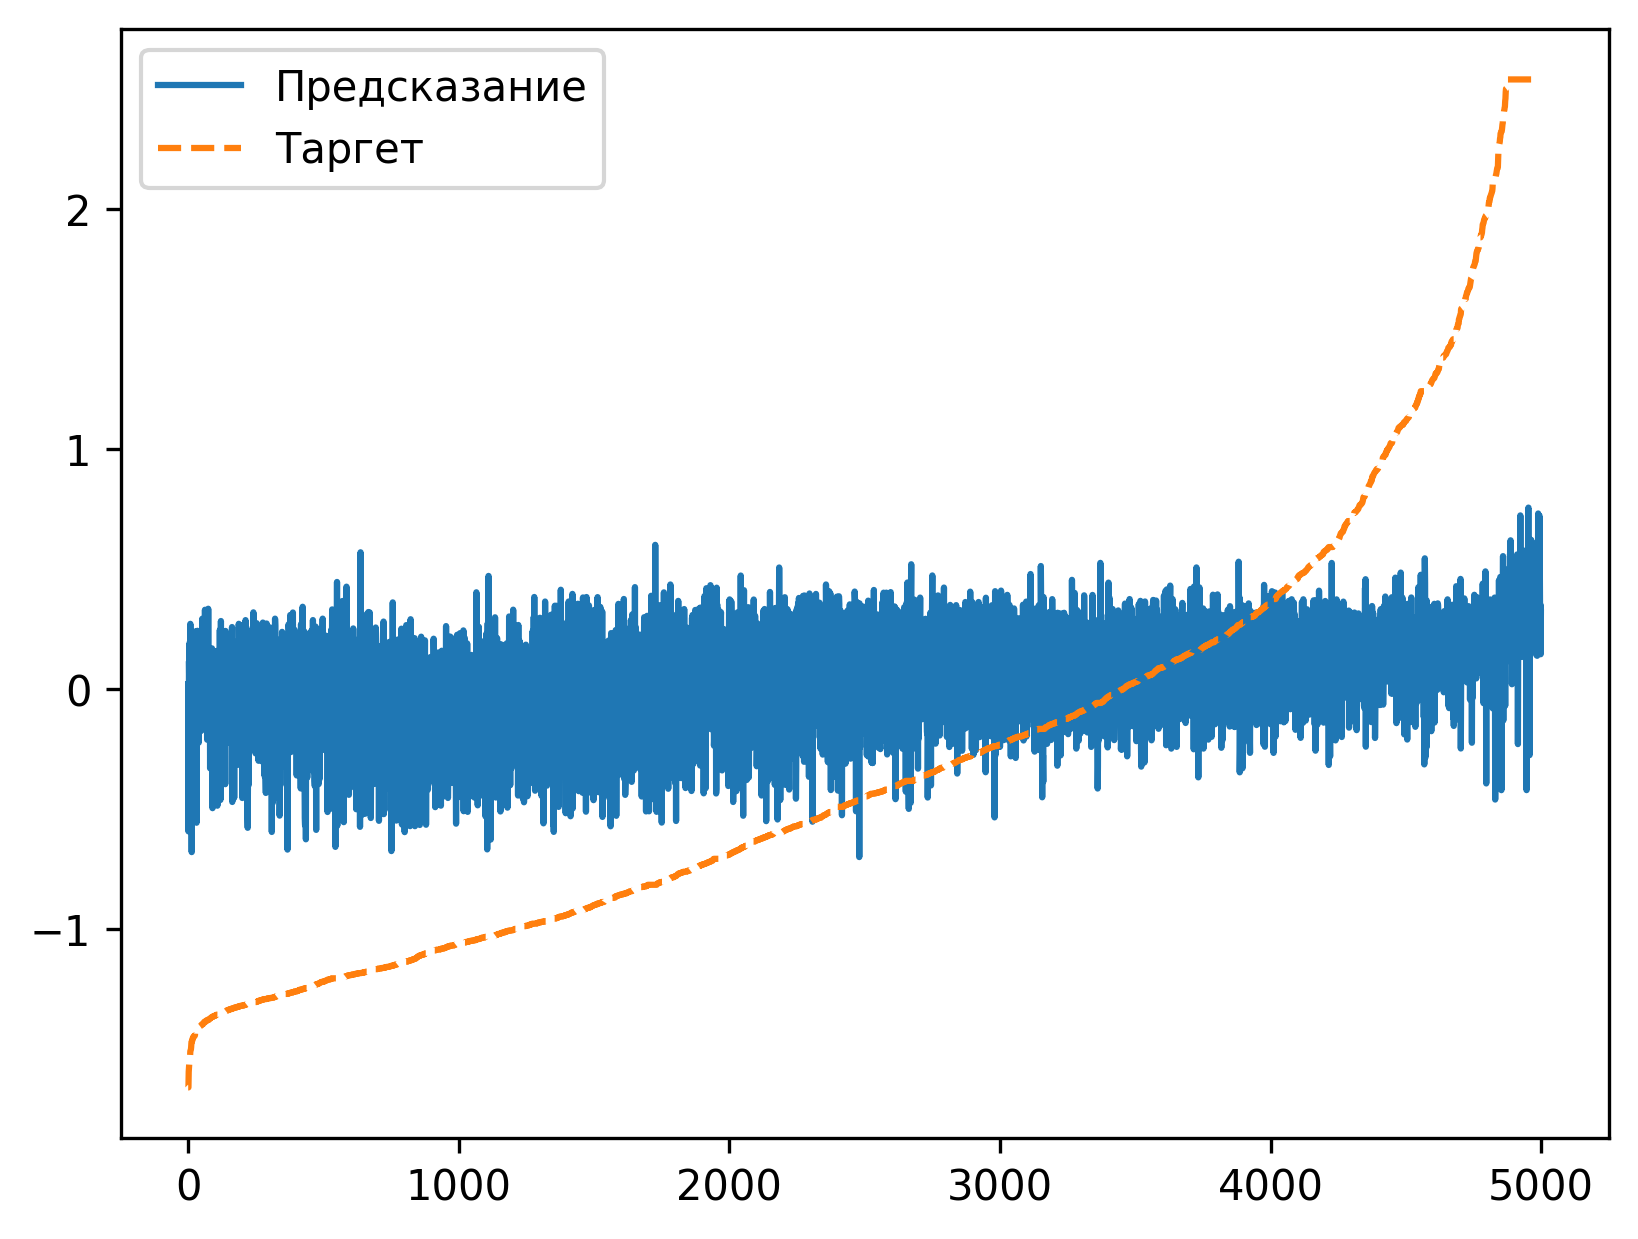

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

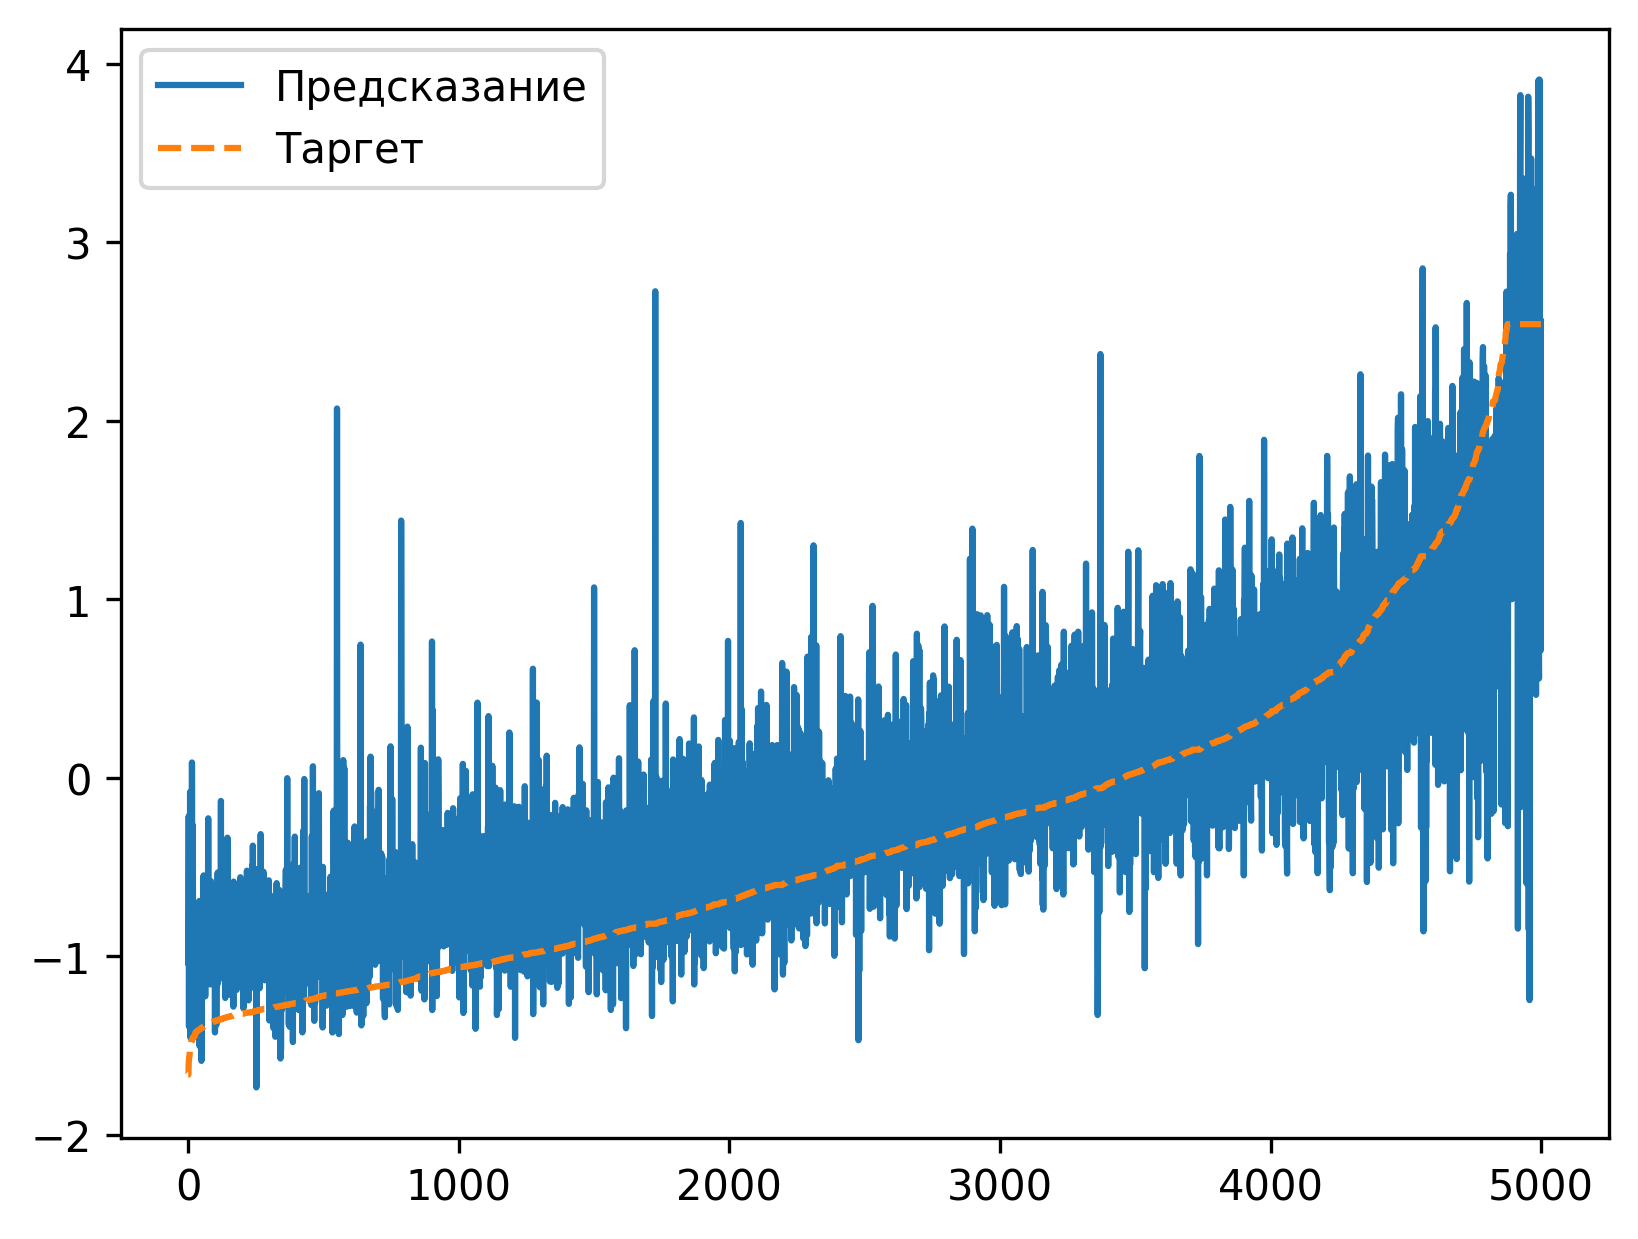

Validation: |          | 0/? [00:00<?, ?it/s]

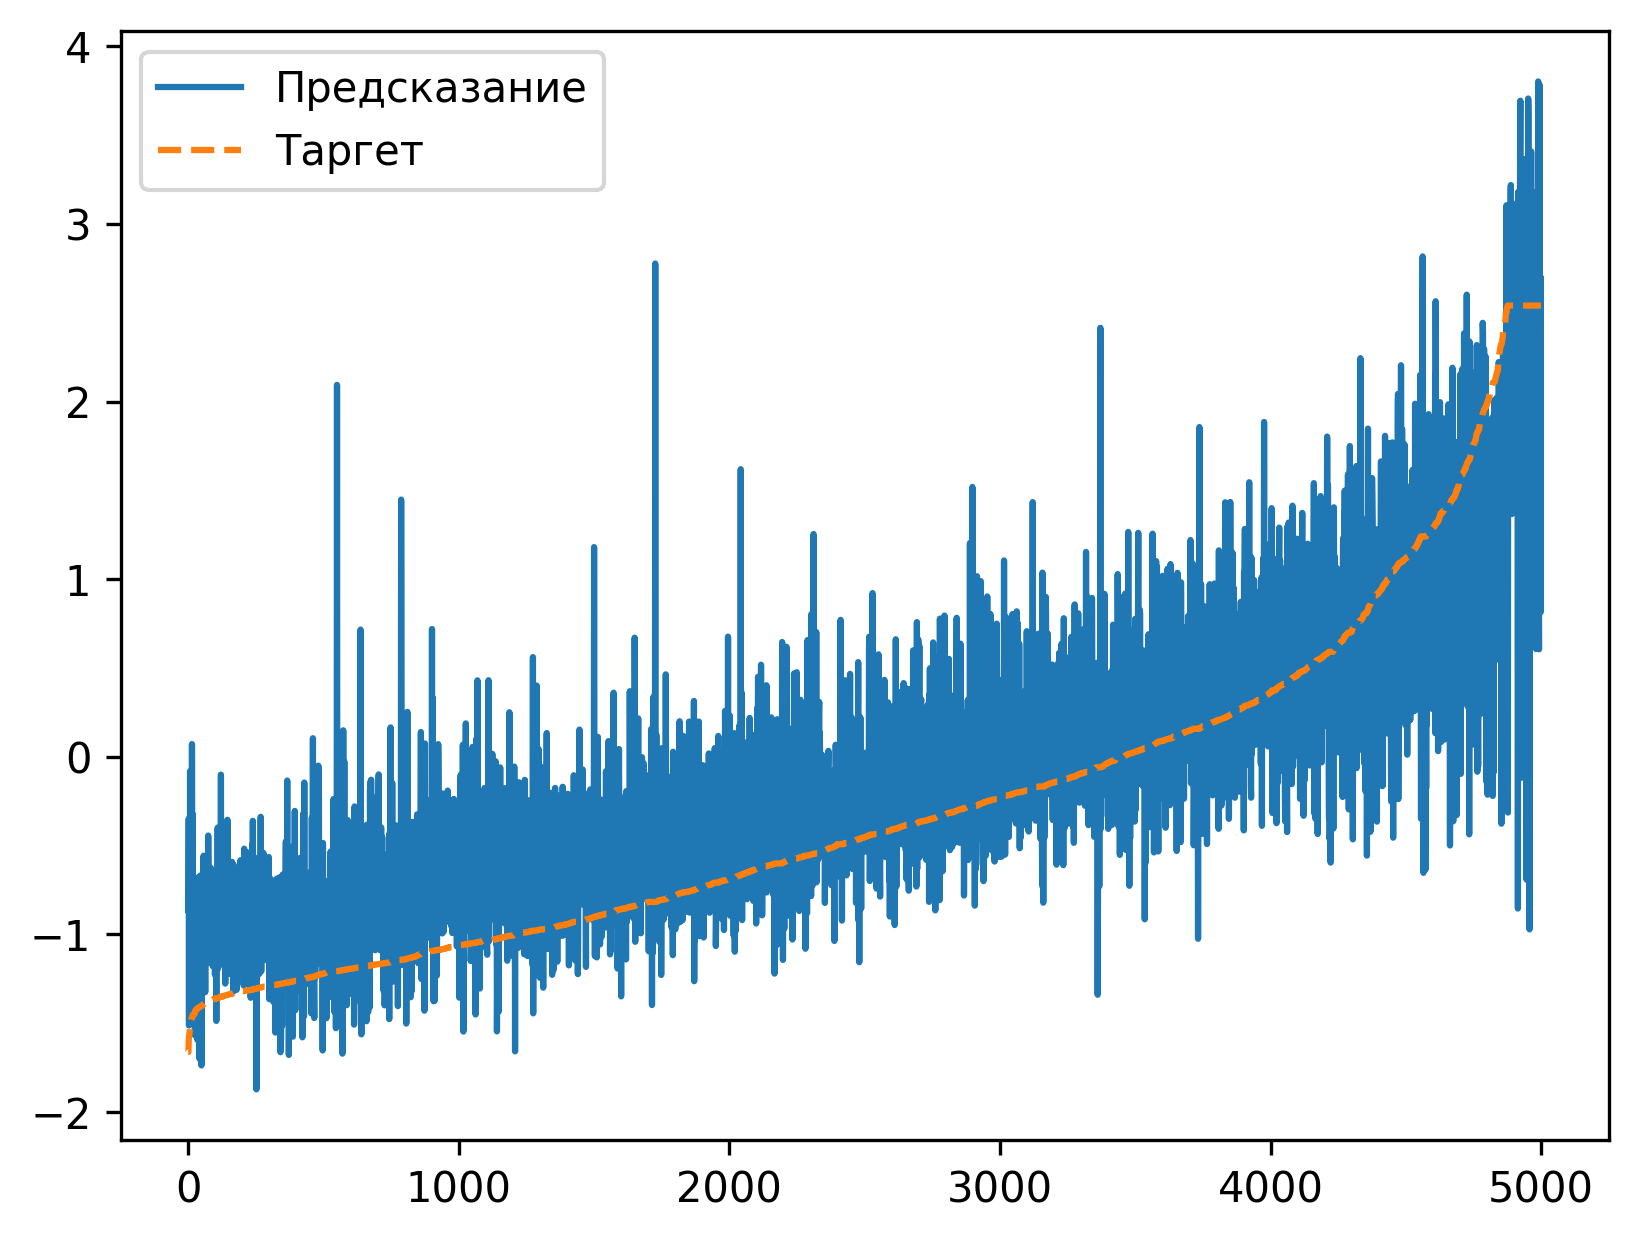

`Trainer.fit` stopped: `max_epochs=100` reached.


In [12]:
MAX_EPOCHS = 100

df = pd.read_csv("data/housing.csv")
df_num = df.select_dtypes(exclude=object)
df_num = df_num.fillna(0)
df_num = (df_num - df_num.mean()) / df_num.std()
target = "median_house_value"
X_df = df_num.drop(columns=target)
y = df_num[target]

dataset = HousingDataset(X=X_df, y=y)
dataloader = DataLoader(dataset, batch_size=1000)
val_dataloader = DataLoader(dataset, batch_size=5000, shuffle=False)

model = HouseModel(X_df.shape[1], lr=1e-2)
trainer = pl.Trainer(max_epochs=MAX_EPOCHS, check_val_every_n_epoch=50, log_every_n_steps=1)
with warnings.catch_warnings():
    warnings.filterwarnings(action="ignore", message=".*does not have many workers.*")
    trainer.fit(model, dataloader, val_dataloader)

Задача: попробуйте поменять архитектуру/learning rate, есть ли изменения в обучении модели?

Что можно отметить:
- Хрупкость НН (уязвимость к learning rate, масштабу, активациям)
- Большую сложность с точки зрения организации кода